# Hybrid Approach (CNN-BiLSTM)

In [1]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import (Input, Embedding, SpatialDropout1D, Conv1D,
                                     BatchNormalization, Dropout, GlobalMaxPooling1D,
                                     Bidirectional, LSTM, Dense, concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from gensim.downloader import load as gensim_load
from sklearn.metrics import confusion_matrix, classification_report
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaiki\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kaiki\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Load the dataset
df = pd.read_csv("D2.csv")

In [3]:
# Drop the unnecessary column if it exists
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)


In [4]:
# Drop rows with missing values and show new shape
df.dropna(inplace=True)
print("\nShape after dropping missing values:", df.shape)


Shape after dropping missing values: (10391, 3)


In [5]:
# Check distribution of status before resampling
print("\nStatus Value Counts before resampling:")
print(df['status'].value_counts())


Status Value Counts before resampling:
status
neutral          4374
negative         4112
very negative    1155
positive          750
Name: count, dtype: int64


In [6]:
# Data Resampling for Class Balance
def resample_data(df):
    max_count = df['status'].value_counts().max()
    df_resampled = pd.DataFrame()
    for status in df['status'].unique():
        df_class = df[df['status'] == status]
        if len(df_class) < max_count:
            df_class_resampled = resample(df_class, replace=True, n_samples=max_count, random_state=42)
            df_resampled = pd.concat([df_resampled, df_class_resampled])
        else:
            df_resampled = pd.concat([df_resampled, df_class])
    return df_resampled

df = resample_data(df)
print("Value counts after resampling:")
print(df['status'].value_counts())

Value counts after resampling:
status
negative         4374
neutral          4374
positive         4374
very negative    4374
Name: count, dtype: int64


In [7]:
# Text Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text.lower())
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['posts'] = df['posts'].apply(preprocess_text)
print("\nSample preprocessed text:")
print(df['posts'].head())



Sample preprocessed text:
2389    morning hen get bad news aunt cancer spread li...
9588    lose good friend terrible thing call lung canc...
7761    dad 58 cancer leg reach lung dad neglect cance...
1253    mom get throat cancer 6 monthe ago 6 monthe ag...
8703    title say 18 year old terrify colon cancer alr...
Name: posts, dtype: object


In [8]:
# Splitting Data and Encoding Labels
X = df['posts'].values
y = df['status'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (13996,) (13996, 4)
Testing set shape: (3500,) (3500, 4)


In [9]:
# Tokenization and Padding
max_words = 50000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_sequence_length = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')
print("Padded Training Data Shape:", X_train_padded.shape)
print("Padded Testing Data Shape:", X_test_padded.shape)

Padded Training Data Shape: (13996, 100)
Padded Testing Data Shape: (3500, 100)


In [10]:
# Load Pre-trained Word2Vec and Build Embedding Matrix
print("Downloading the pre-trained Google News Word2Vec model. This may take a while...")
word2vec_model = gensim_load("word2vec-google-news-300")
embedding_dim = word2vec_model.vector_size  
print("Download complete. Embedding dimension:", embedding_dim)

word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
found_count = 0

for word, i in word_index.items():
    if i >= max_words:
        continue
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]
        found_count += 1
    else:
        # Initialize missing words with random vectors
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

print(f"Found embeddings for {found_count} out of {num_words} words.")


Download complete. Embedding dimension: 300
Found embeddings for 20006 out of 32979 words.


In [11]:
# Building the Enhanced Hybrid CNN + BiLSTM Model
# Using the Functional API for a parallel architecture:
input_layer = Input(shape=(max_sequence_length,), name='input_text')
embedding_layer = Embedding(input_dim=num_words,
                            output_dim=embedding_dim,
                            input_length=max_sequence_length,
                            weights=[embedding_matrix],
                            trainable=True,
                            name='embedding')(input_layer)
drop_embedding = SpatialDropout1D(0.3, name='spatial_dropout')(embedding_layer)

# CNN Branch: apply several 1D convolutions and global pooling
conv1 = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu', name='conv1_3')(drop_embedding)
bn1   = BatchNormalization(name='bn1')(conv1)
conv2 = Conv1D(filters=256, kernel_size=4, padding='same', activation='relu', name='conv2_4')(bn1)
bn2   = BatchNormalization(name='bn2')(conv2)
conv3 = Conv1D(filters=256, kernel_size=5, padding='same', activation='relu', name='conv3_5')(bn2)
bn3   = BatchNormalization(name='bn3')(conv3)
pool  = GlobalMaxPooling1D(name='global_max_pool')(bn3)

# BiLSTM Branch: capture sequential context
bilstm = Bidirectional(LSTM(units=128, dropout=0.3, recurrent_dropout=0.3), name='bilstm')(drop_embedding)
drop_bilstm = Dropout(0.5, name='drop_bilstm')(bilstm)

# Merge both branches
merged = concatenate([pool, drop_bilstm], name='concatenate')

# Fully connected layers after merging
fc1 = Dense(128, activation='relu', name='fc1')(merged)
bn_fc1 = BatchNormalization(name='bn_fc1')(fc1)
drop_fc1 = Dropout(0.5, name='drop_fc1')(bn_fc1)

# Output layer for multi-class classification
output_layer = Dense(y_categorical.shape[1], activation='softmax', name='output')(drop_fc1)

# Build and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

C:\Users\kaiki\Documents\anaconda\envs\tensorflow_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_text (InputLayer)       │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 100, 300)          │       9,893,700 │ input_text[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ spatial_dropout               │ (None, 100, 300)          │               0 │ embedding[0][0]            │
│ (SpatialDropout1D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_3 (Conv1D)              │ (None, 100, 256)          │         230,656 │ spatial_dropout[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn1 (BatchNormalization)      │ (None, 100, 256)          │           1,024 │ conv1_3[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_4 (Conv1D)              │ (None, 100, 256)          │         262,400 │ bn1[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn2 (BatchNormalization)      │ (None, 100, 256)          │           1,024 │ conv2_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3_5 (Conv1D)              │ (None, 100, 256)          │         327,936 │ bn2[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn3 (BatchNormalization)      │ (None, 100, 256)          │           1,024 │ conv3_5[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bilstm (Bidirectional)        │ (None, 256)               │         439,296 │ spatial_dropout[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pool               │ (None, 256)               │               0 │ bn3[0][0]                  │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ drop_bilstm (Dropout)         │ (None, 256)               │               0 │ bilstm[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 512)               │               0 │ global_max_pool[0][0],     │
│                               │                           │                 │ drop_bilstm[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ fc1 (Dense)                   │ (None, 128)               │          65,664 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_fc1 (BatchNormalization)   │ (None, 128)               │             512 │ fc1[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ drop_fc1 (Dropout)            │ (None, 128)               │               

 Total params: 11,223,752 (42.82 MB)

 Trainable params: 11,221,960 (42.81 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [12]:
# Model Training with Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history = model.fit(X_train_padded, y_train,
                    epochs=25,
                    batch_size=128,
                    validation_data=(X_test_padded, y_test),
                    callbacks=[early_stop, reduce_lr])


Epoch 1/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 80s 681ms/step - accuracy: 0.4044 - loss: 1.5163 - val_accuracy: 0.4034 - val_loss: 1.1977 - learning_rate: 0.0010
Epoch 2/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 74s 670ms/step - accuracy: 0.7376 - loss: 0.6926 - val_accuracy: 0.5551 - val_loss: 1.1039 - learning_rate: 0.0010
Epoch 3/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 72s 653ms/step - accuracy: 0.8516 - loss: 0.3973 - val_accuracy: 0.7460 - val_loss: 0.6027 - learning_rate: 0.0010
Epoch 4/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 70s 635ms/step - accuracy: 0.9005 - loss: 0.2767 - val_accuracy: 0.8954 - val_loss: 0.2805 - learning_rate: 0.0010
Epoch 5/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 72s 654ms/step - accuracy: 0.9360 - loss: 0.1982 - val_accuracy: 0.8831 - val_loss: 0.3305 - learning_rate: 0.0010
Epoch 6/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 70s 634ms/step - accuracy: 0.9499 - loss: 0.1562 - val_accuracy: 0.9194 - val_loss: 0.2640 - learning_rate: 0.0010
Epoch 7/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 71s 645ms/step - accuracy: 0.9

In [13]:
# Evaluating the Model
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print("\nTest Accuracy: {:.2f}%".format(test_accuracy * 100))

110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9231 - loss: 0.2484

Test Accuracy: 91.94%


110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step
Confusion Matrix:
[[690 133   9  41]
 [ 52 792  23   7]
 [  1   1 900   2]
 [ 12   1   0 836]]


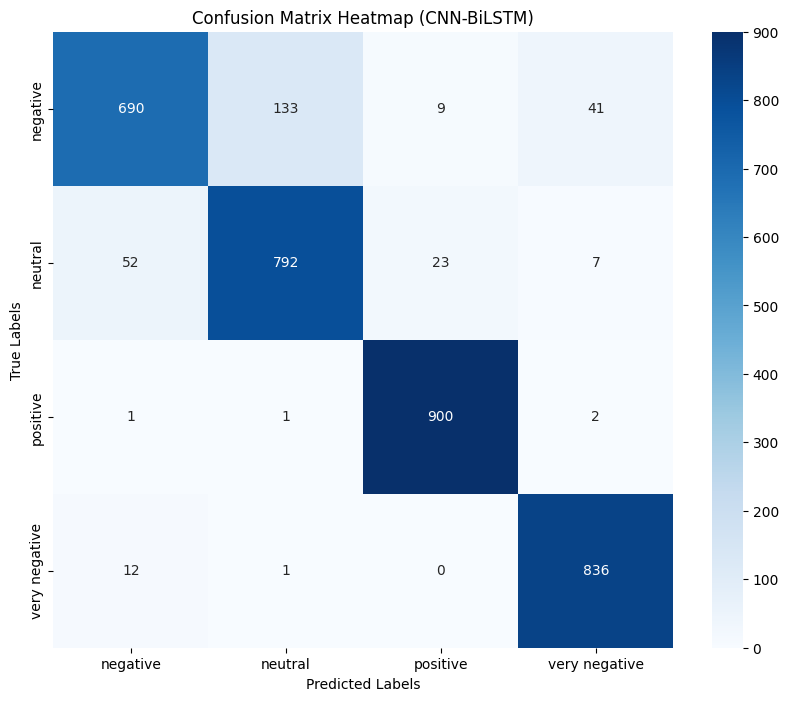

Classification Report:
               precision    recall  f1-score   support

     negative     0.9139    0.7904    0.8477       873
      neutral     0.8544    0.9062    0.8795       874
     positive     0.9657    0.9956    0.9804       904
very negative     0.9436    0.9847    0.9637       849

     accuracy                         0.9194      3500
    macro avg     0.9194    0.9192    0.9178      3500
 weighted avg     0.9196    0.9194    0.9180      3500



In [14]:
# Generate predictions and compute evaluation metrics
y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap (CNN-BiLSTM)')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, digits=4))

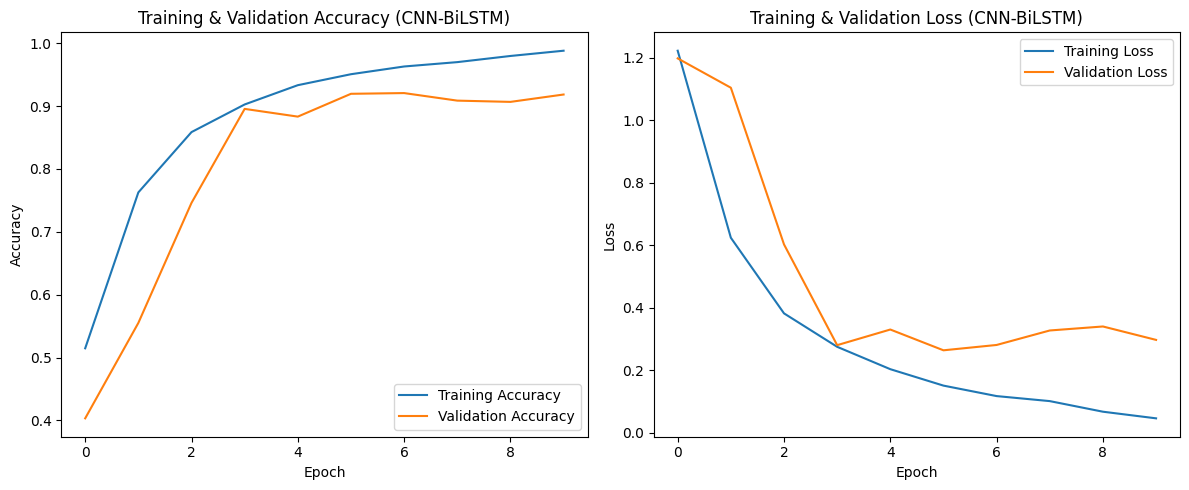

In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy (CNN-BiLSTM)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss (CNN-BiLSTM)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


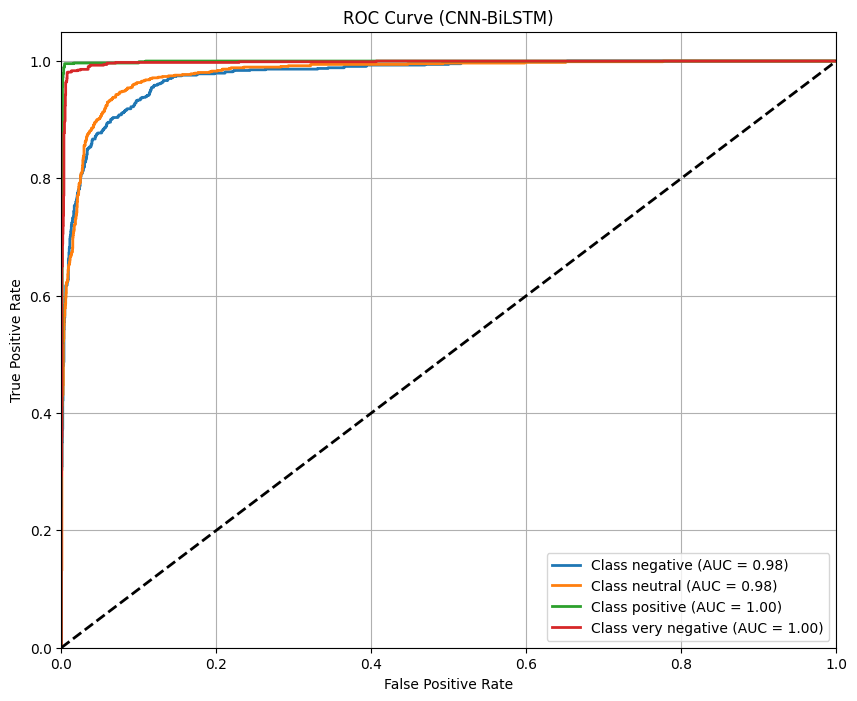

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ROC curve setup
n_classes = y_categorical.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves using a colormap 
plt.figure(figsize=(10, 8))
colors = plt.cm.tab10.colors  

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2,
             label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (CNN-BiLSTM)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



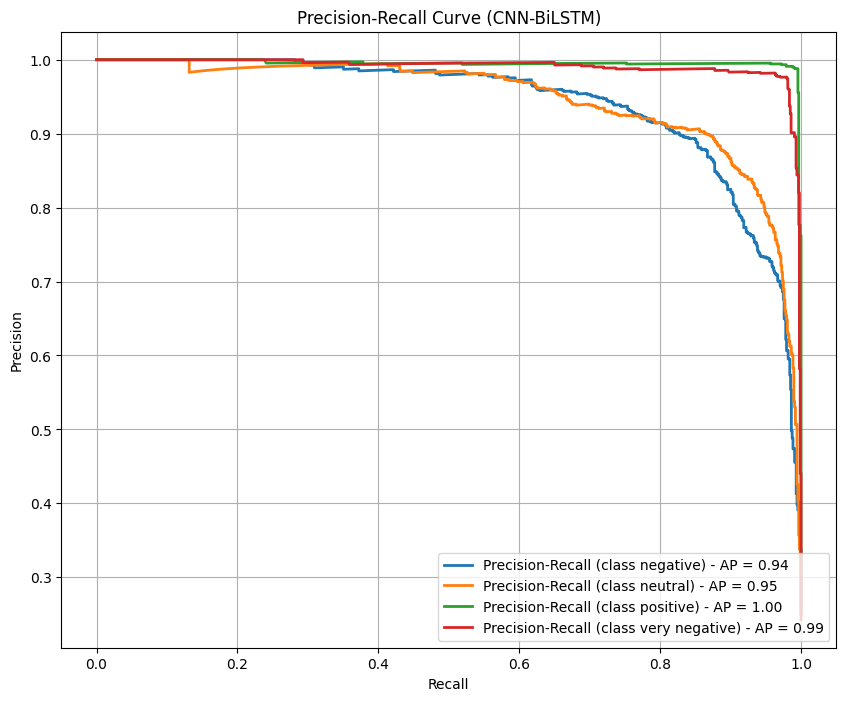

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall curve and average precision for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred_probs[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred_probs[:, i])

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Precision-Recall (class {label_encoder.classes_[i]}) - AP = {average_precision[i]:0.2f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (CNN-BiLSTM)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

